# 1. Goals

Analyse data and develop prediction models for the concentration of CO2 on the atmosphere and the global temperature from 1850 onwards.

In this respect, the following tasks are performed:
1. Statistics: Analyse relevant statistics, such as autocorrelation, stationarity, trend, seasonality and noise
2. Correlation vs Causation: analyse and discuss the relationship between CO2 concentration and global temperature
3. Prediction: develop and evaluate a prediction model;
4. Prediction with support Series: develop a prediction model for Global Temperature using CO2 concentration as a support series

# 2. Imports and Utility functions

In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.stats import yeojohnson
import statsmodels.api as sm
import itertools
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import grangercausalitytests
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [3]:
def load_data(path, **kwargs):
    
    return pd.read_csv(path, **kwargs)

In [4]:
def simple_detrend(timeseries, periods=25):
    
    _detrended = (timeseries - timeseries.rolling(periods).mean()).dropna()
    return _detrended

In [5]:
def plot_timeseries(timeseries, figsize=(8,6)):
    """Utility function to plot timeseries data controlling figsize"""
    
    plt.figure(figsize=figsize)
    timeseries.plot()
    plt.title(timeseries.name)
    plt.xticks(rotation='vertical')
    plt.show()
    
    return None

In [6]:
def test_adfuller(timeseries):
    """Perform Dickey-Fuller test on `timeseries` and display results"""
    
    print('Results of Dickey-Fuller Test:')
    adf_test = adfuller(timeseries, autolag='AIC')
    adf_out = pd.Series(adf_test[0:4], index=['Test Statistic','p-value','# of Lags', '# of Observations'])
    for key, value in adf_test[4].items():
        adf_out[f'Critical Value {key}'] = value
    print(adf_out)
    
    return None

In [7]:
def plot_rolling_mean(timeseries, window=12, figsize=(8,6)):
    """Utility function to determine rolling mean and plot data"""
    
    #Determing rolling statistics
    roll_mean = timeseries.rolling(window=window).mean()

    #Plot rolling statistics:
    plt.figure(figsize=figsize)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title(f'{timeseries.name} \nRolling Mean')
    
    return None

In [8]:
def plot_rolling_mean_std(timeseries, window=12, figsize=(8,6)):
    """Displays a plot of the original `timeseries` alongside a rolling
    mean and rolling standard deviation for visual inspection.
    
    Original source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/"""
    
    #Determing rolling statistics
    roll_mean = timeseries.rolling(window=window).mean()
    roll_std = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    plt.figure(figsize=figsize)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title(f'{timeseries.name} \nRolling Mean & Rolling Standard Deviation')
    
    return None

In [9]:
def plot_boxcox_yeojonson_transf(timeseries):
    """Utility function to visualize distributions of 
    original data, Box-Cox transformed and Yeo-Johnson 
    transformed versions"""
    
    # compute Box-Cox transform
    bc_timeseries_values, bc_lambda = boxcox(timeseries)
    bc_timeseries = pd.Series(
        data=bc_timeseries_values,
        index=timeseries.index)

    # compute YeoJohnson transform
    yj_timeseries_values, yj_lambda = yeojohnson(timeseries)
    yj_timeseries = pd.Series(
        data=yj_timeseries_values,
        index=timeseries.index)

    # plot original and both transforms
    f, axes = plt.subplots(ncols=3, figsize=(18, 6))
    timeseries.hist(ax=axes[0])
    bc_timeseries.hist(ax=axes[1])
    yj_timeseries.hist(ax=axes[2])

    # set titles
    axes[0].set_title(f"{timeseries.name}")
    axes[1].set_title(f"Box-cox Transformed \n{timeseries.name}")
    axes[2].set_title(f"Yeo-Johnson Transformed \n{timeseries.name}")

    plt.show()
    
    return None

In [10]:
def plot_yearly_boxplot(timeseries, figsize=(8,6)):
    """Plot a boxplot of the `timeseries` grouped by year."""

    plt.figure(figsize=figsize)
    sns.boxplot(timeseries.index.year, timeseries)
    plt.xticks(rotation='vertical')
    plt.title(f'Boxplot - Yearly - {timeseries.name}')
    plt.show()
    
    return None

In [11]:
def plot_bin_stats(timeseries, stats_ls=['mean', 'std'], n_bins=15, figsize=(12,6)):
    """Displays mean and standard deviation by user-defined number of bins.
    Splits using index."""
    
    data_col = timeseries.name
    data_df = pd.DataFrame(timeseries)
    data_df['bins'] = pd.cut(timeseries.index.values, bins=n_bins)
    data_df.groupby('bins')[data_col].agg(stats_ls).plot(figsize=figsize)
    plt.xticks(rotation='vertical')
    plt.title(timeseries.name)
    plt.show()
    
    return None

In [12]:
def extract_seasonal_decomp_features(timeseries, freq, model='additive'):
    """Applies a seasonal decomposition to `timeseries` and returns each
    feature"""
    
    # decompse the timeseries and extract each series
    decomposition = seasonal_decompose(timeseries, freq=freq, model=model)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    return trend, seasonal, residual

In [13]:
def plot_decomp(decomp_results, figsize=(16,12)):
    """Display each element of a seasonal decomposition of a timeseries
    in a separate plot."""
    
    observed = decomp_results.observed
    trend = decomp_results.trend
    seasonal = decomp_results.seasonal
    resid = decomp_results.resid
    
    plt.figure(figsize=figsize)
    plt.subplot(411)
    plt.plot(observed)
    plt.title('Observed')
    plt.subplot(412)
    plt.plot(trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(seasonal)
    plt.title('Seasonality')
    plt.subplot(414)
    plt.plot(resid)
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()
    
    return None

In [14]:
def plot_decomposition(timeseries, trend, seasonal, residual):
    """Display each element of a seasonal decomposition of a timeseries
    in a separate plot."""

    plt.figure(figsize=(16,12))
    plt.subplot(411)
    plt.plot(timeseries)
    plt.title('Original')
    plt.subplot(412)
    plt.plot(trend)
    plt.title('Trend')
    plt.subplot(413)
    plt.plot(seasonal)
    plt.title('Seasonality')
    plt.subplot(414)
    plt.plot(residual)
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()
    
    return None

In [15]:
def plot_acf_pacf(timeseries, nlags=5):
    """Utility function to dispaly AutoCorrelation Function and
    Partial AutoCorrelation Function plots
    
    Original source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/"""
    
    lag_acf = tsa.acf(timeseries, nlags=nlags)
    lag_pacf = tsa.pacf(timeseries, nlags=nlags, method='ols')
    
    # adjust plot settings and plot
    plt.figure(figsize=(16,8))
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(timeseries)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()
    
    return None

In [16]:
def mean_absolute_percentage_error(y_true, y_predicted):
    """Utility function to compute Mean Absolutte Percentage Error"""

    return np.mean(np.abs((y_true - y_predicted) / y_true)) * 100

In [17]:
def plot_predictions(y_train, y_test, y_predicted, title, figsize=(12,8)):
    """Utility function to plot predicted values alongside
    train and test sets"""
    
    plt.figure(figsize=figsize)
    plt.plot(y_train, label='Train')
    plt.plot(y_test, label='Test')
    plt.plot(y_predicted, label=title)
    plt.legend(loc='best')
    plt.title(title)
    plt.show()

    return None

In [18]:
def find_sarima_param(y_train, seasonal_period=12):
    """Function iterate over combinarions of ARIMA (p,d,q) order
    and seasonal order (p,d,q,m) and find best combination using
    Akaike Information Criterion.
    
    Original source: https://github.com/gianfelton/SARIMA-Param-Search-for-Python/blob/master/Seasonal%20ARIMA%20with%20Param%20Search.ipynb"""
    
    p = d = q = range(0, 2)
    pdq = itertools.product(p, d, q)
    seasonal_pdq = ((x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q)))

    results_ls = []
    results_dict = {}
    for pdq_order in pdq:
        for seasonal_pdq_order in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(y_train,
                                                  order=pdq_order,
                                                  seasonal_order=seasonal_pdq_order)

                results = model.fit()
                results_dict = {'aic':results.aic, 'order':pdq_order,
                                'seasonal_order':seasonal_pdq_order}
                results_ls.append(results_dict)
            except:
                pass

        results_df = pd.DataFrame(results_ls)
    
    lowest_aic_idx = results_df['aic'].idxmin()

    summary = {'aic': results_df.iloc[lowest_aic_idx, 0],
               'order': results_df.iloc[lowest_aic_idx, 1], 
               'seasonal_order': results_df.iloc[lowest_aic_idx, 2]}
    
    return summary

In [19]:
def print_diagnostics(true_values, predicted_values, print_message):
    """Utility function to print RMSE, MAPE and and plots the residuals"""
    
    print(f'{print_message}')
    print(f'RMSE: {np.sqrt(mean_squared_error(true_values, predicted_values))}')
    print(f'MAPE: {mean_absolute_percentage_error(true_values, predicted_values)}')
    
    residuals = true_values - predicted_values
    residuals.hist()
    plt.title('Residuals')
    plot_acf(residuals)
    
    plt.show()
    return None

# 3. Load Data

CO2 data is sourced from the [ETH Zurich's Institute for Atmospheric and Climate Science](https://iac.ethz.ch/). Global Temperature Data is available as a [Kaggle Dataset](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data/data#GlobalTemperatures.csv), but it downloaded here from my personal GitHub account where it was made available to avoid using the Kaggle API.

In [20]:
# load data
CO2_FILE = './data/mole_fraction_co2.csv'
TEMPERATURE_FILE = './data/temperature.csv'

In [21]:
co2_rawdata = load_data(CO2_FILE, header=0, index_col=4, parse_dates=True)
temp_rawdata = load_data(TEMPERATURE_FILE, header=0, index_col=0, parse_dates=True)

# 4. Task \#1: Time Series Analysis

As the name states, Time Series analysis (and modelling) involves analysing and modelling the effect of the time in a particular process.

When attempting to model such processes, most of the classical tools make strong assumptions about the behavior of the data. Arguably the strongest one is that of a stationary process. This definition can be found accross the web, but one very succint explanation can be found on an [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/) blog post:

"
*Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:*
    
- *constant mean*
- *constant variance*
- *an autocovariance that does not depend on time.*
"

Usually, Stationarity testing and converting a time series into a stationary series are the most critical processes in a time series modelling, as most models rely on this structure. This we be the main task of this report in order to developed the prediction models.

**Analysing Stationarity, Trend, Seasonality and Noise**

Inspecting stationarity can be done both visually and statistically.

The visual aspect will make use of some Python libraries and plots. Some utility functions are defined within this Notebook, and others available through imports.

The statistical part in this report is performed through the Augmented Dick-Fuller test. It tests for a null-hypothesis that Time Series is non-stationarity, i.e., that it has some time-dependent structure.

This is done through a Test Statistic and associated p-value:
- if p-value < confidence level (usually 5%) => null hypothesis should be rejected, and the series should be considered stationary
- if p-value > confidence level (usually 5%) => fail to reject the null hypothesis, and the series should be considered non-stationary

## 4.1. Global Temperature Data

First, a few exploratory actions and plots.

In [22]:
temp_rawdata.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
temp_rawdata.describe()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
count,3180.000000,3180.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000,1992.000000
mean,8.374731,0.938468,14.350601,0.479782,2.743595,0.431849,15.212566,0.128532
std,4.381310,1.096440,4.309579,0.583203,4.155835,0.445838,1.274093,0.073587
min,-2.080000,0.034000,5.900000,0.044000,-5.407000,0.045000,12.475000,0.042000
25%,4.312000,0.186750,10.212000,0.142000,-1.334500,0.155000,14.047000,0.063000
50%,8.610500,0.392000,14.760000,0.252000,2.949500,0.279000,15.251000,0.122000
75%,12.548250,1.419250,18.451500,0.539000,6.778750,0.458250,16.396250,0.151000
max,19.021000,7.880000,21.320000,4.373000,9.715000,3.498000,17.611000,0.457000


In [24]:
temp_rawdata.isna().sum()

LandAverageTemperature                         12
LandAverageTemperatureUncertainty              12
LandMaxTemperature                           1200
LandMaxTemperatureUncertainty                1200
LandMinTemperature                           1200
LandMinTemperatureUncertainty                1200
LandAndOceanAverageTemperature               1200
LandAndOceanAverageTemperatureUncertainty    1200
dtype: int64

Overall there's a lot of data available. Since we're lookign at a global temperature perspective, it seems both appropriate and more simple to select the **Land and Ocean Average Temperature** time series for this analysis.

**Exploratory Data Analysis**

In [25]:
landocean_temp = temp_rawdata['1850':]['LandAndOceanAverageTemperature']

In [26]:
landocean_temp.describe()

count    1992.000000
mean       15.212566
std         1.274093
min        12.475000
25%        14.047000
50%        15.251000
75%        16.396250
max        17.611000
Name: LandAndOceanAverageTemperature, dtype: float64

In [27]:
landocean_temp.isna().sum()

0

At this point, the datatype seems fine, no absurd values are present and there's no need for inputations, since no Null value is present.

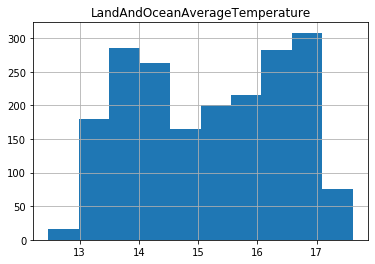

In [28]:
# looking at the distribution of the data
landocean_temp.hist()
plt.title(landocean_temp.name)
plt.show()

The histogram suggests that the data is Gaussian-like, but not exactly normal. Since most tests assume a Gaussian-like distribution, it's worth looking into transformations such as Box-Cox or Yeo-Johnson.

These transformations also help stabilizing the non-constant variance of a series, which may be helpful.

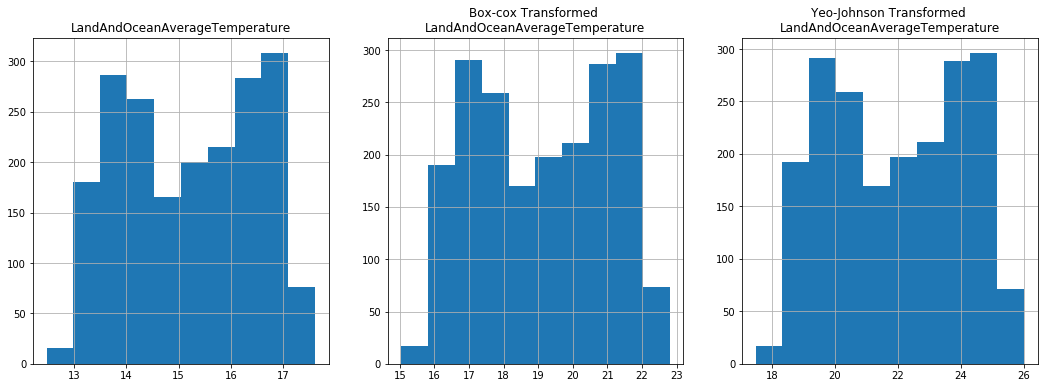

In [29]:
plot_boxcox_yeojonson_transf(landocean_temp)

For simplicity, since in this case they yield very similar distributions, no transformation will be applied.

**Visual Stationarity inspection**

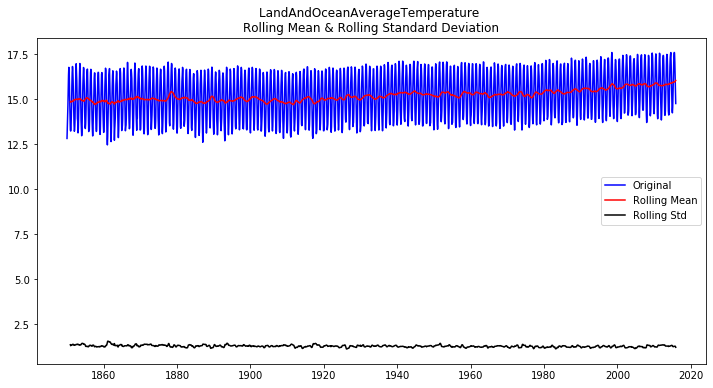

In [30]:
plot_rolling_mean_std(landocean_temp, window=12, figsize=(12,6))

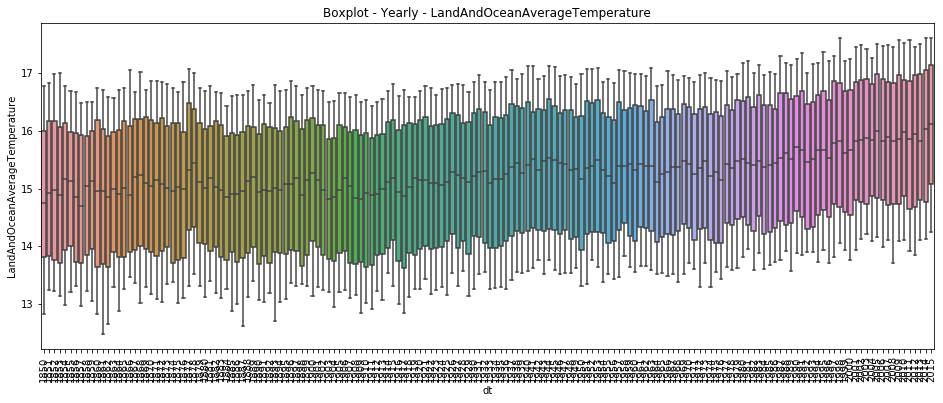

In [31]:
plot_yearly_boxplot(landocean_temp, figsize=(16,6))

On a smaller number of "groups" (or bins).

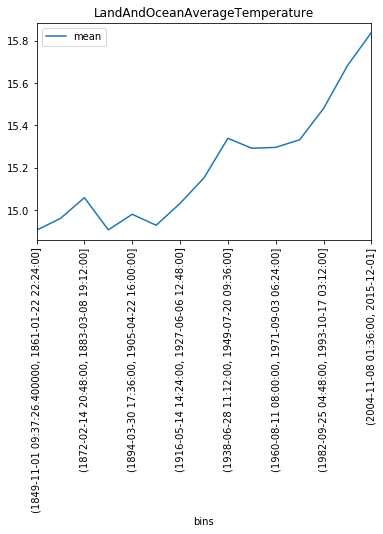

In [32]:
plot_bin_stats(landocean_temp, stats_ls=['mean'], figsize=(6,4))

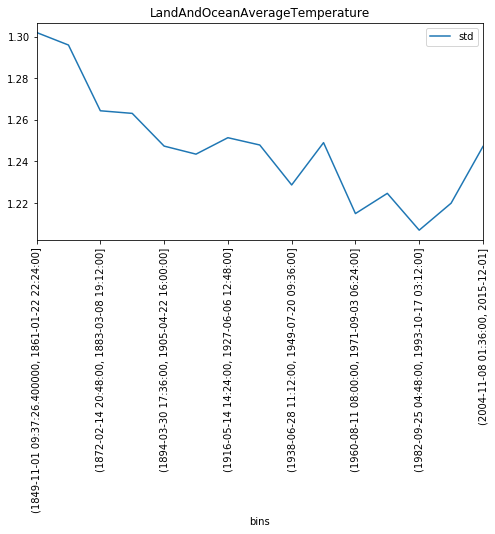

In [33]:
plot_bin_stats(landocean_temp, stats_ls=['std'], figsize=(8,4))

After the brief inspection above:
- data has a slight upward trend
- variance displays changes across time, althouhg close.

Moving on we decompose the timeseries and identify its components. Identifying seasonality is a key aspect, both the period and the type.

About period, the hypothesis is that, as it is a climate process, a seasonal period of 12 months applies.

In order to confirm this hypothesis, we use the ACF plot to identify peak values (high auto-correlation between data points) in lags other than 1.
In order to better visualize and investigate the seasonality, de-trending the series is good practice. A simple rolling mean with a high number of steps is good enough.

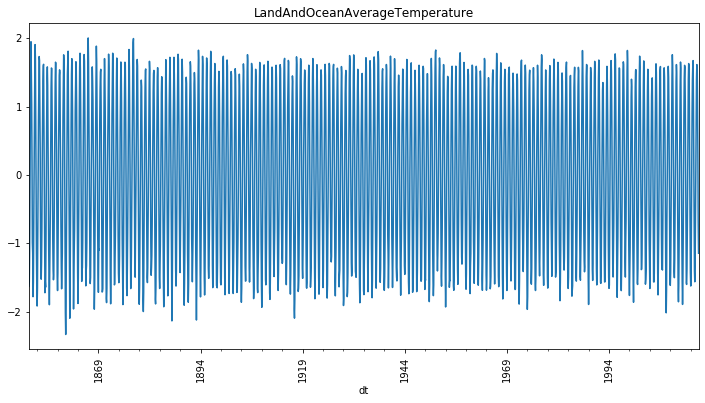

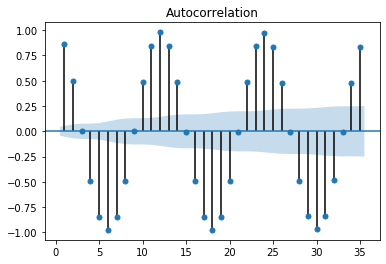

In [34]:
landocean_detrended = simple_detrend(landocean_temp)
plot_timeseries(landocean_detrended, figsize=(12,6))
plot_acf(landocean_detrended, lags=35, zero=False);

With the trend gone, the ACF plot reveals a pattern of peaks at period 12, suggesting a seasonal period of 12 applies.

Additionally, as observed from visual inspection, the type of seasonality seems to be additive: when the seasonal effect adds up to the trend.

Although there is some change in the variance with time, the boxplots suggest the difference may not be significant. So we assume an additive model applies.

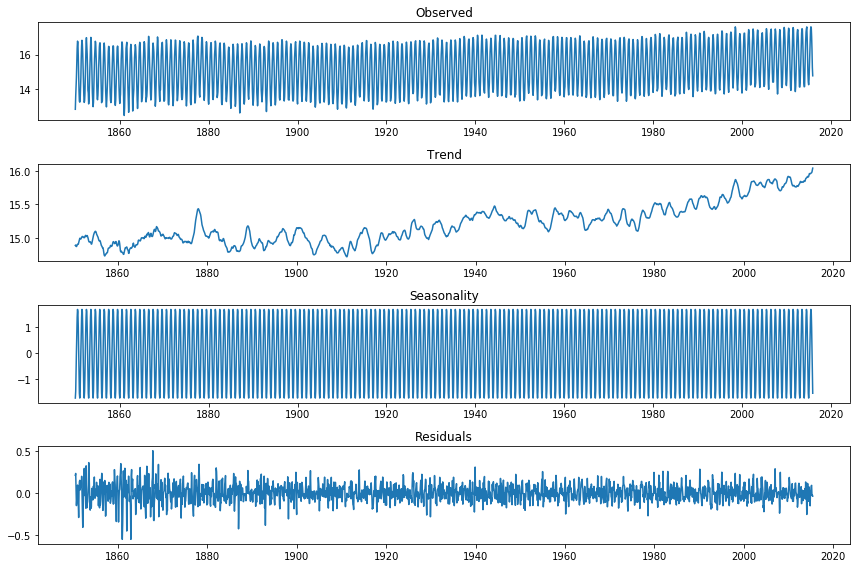

In [35]:
landocean_decomp = seasonal_decompose(landocean_temp, freq=12, model='aditive')
plot_decomp(landocean_decomp, figsize=(12, 8))

After removing the trend and seasonality, a seemingly stationary process was achieved.

In order investigate non-seasonal and seasonal auto-regressive and moving average model orders, we apply a first order difference as a de-trending step, then the seasonal differencing to remove trend and investigate what is left (the residuals).

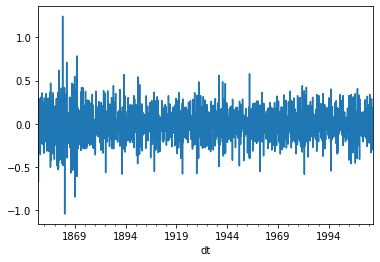

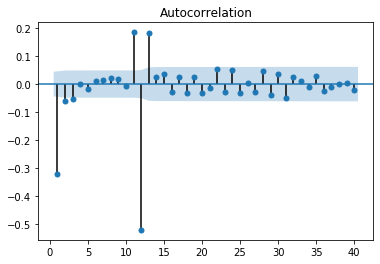

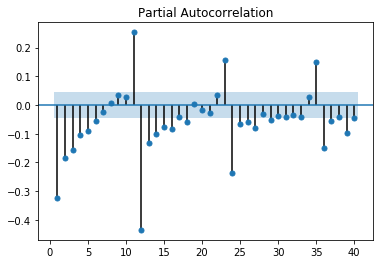

In [36]:
landocean_transf = landocean_temp.diff().diff(12).dropna()
landocean_transf.plot()
plot_acf(landocean_transf, lags=40, zero=False)
plot_pacf(landocean_transf, lags=40, zero=False)
plt.show()

And investigating a the short period of greater standard deviation after 1990:

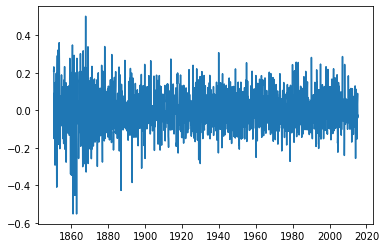

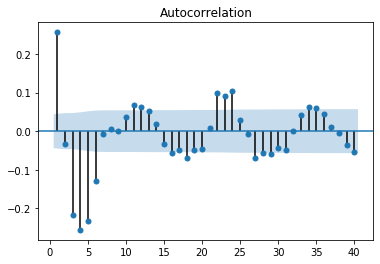

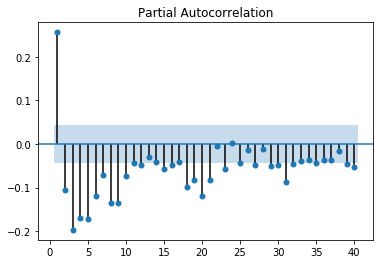

Results of Dickey-Fuller Test:
Test Statistic       -1.457839e+01
p-value               4.509966e-27
# of Lags             2.600000e+01
# of Observations     1.953000e+03
Critical Value 1%    -3.433703e+00
Critical Value 5%    -2.863021e+00
Critical Value 10%   -2.567558e+00
dtype: float64
None


In [37]:
landocean_resid = landocean_decomp.resid
plt.plot(landocean_resid)
plot_acf(landocean_resid.dropna(), lags=40, zero=False)
plot_pacf(landocean_resid.dropna(), lags=40, zero=False)
plt.show()
print(test_adfuller(landocean_resid.dropna()))

We verify that the Land and Ocean Temperature is non-stationary, because:
- There's an upward trend
- There's a strong seasonal component, of period 12

The variance of the process seems to be time dependent, but the boxplot for each year seems to suggest the difference is not that significant.

Additionally, analysing the resulting process after a first order difference and a seasonal differencing with period 12, the residual process could be considered stationary.

## 4.2. CO2 Data

In [38]:
co2_rawdata.head()

,datenum,year,month,day,data_mean_global,data_mean_nh,data_mean_sh
datetime,,,,,,,
15-Jan-0000 00:00:00,15,0,1,15,278.366439,279.045659,277.687219
15-Feb-0000 00:00:00,46,0,2,15,278.713058,279.665398,277.760718
15-Mar-0000 00:00:00,75,0,3,15,279.013835,280.266779,277.760892
15-Apr-0000 00:00:00,106,0,4,15,279.209613,280.756607,277.662620
15-May-0000 00:00:00,136,0,5,15,279.106444,280.613494,277.599394


In [39]:
co2_treated = co2_rawdata.where(co2_rawdata.year >= 1850).dropna()
co2 = co2_treated.data_mean_global.rename('GlobalCO2')
co2 = co2.reindex(pd.to_datetime(co2.index))

In [40]:
co2.isna().sum()

0

Inspecting the distribution of data, we see a skewed distribution, tailing off to the right.

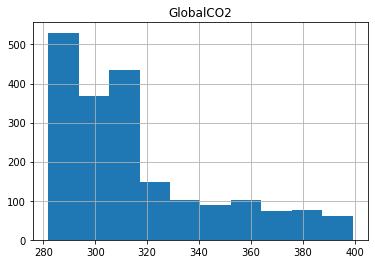

In [41]:
co2.hist(figsize=(6,4))
plt.title(co2.name)
plt.show()

Now considering the time component:

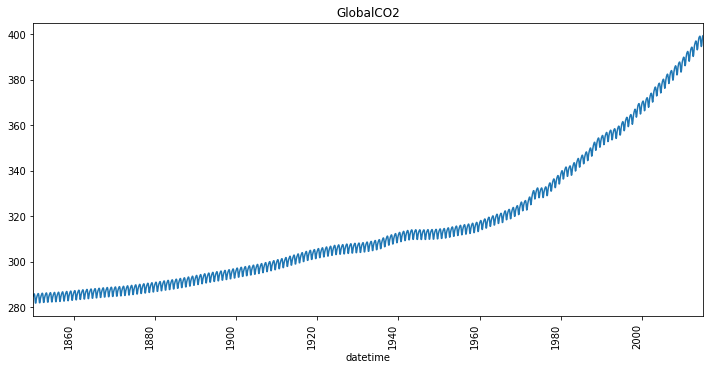

In [42]:
plot_timeseries(co2, figsize=(12,6))

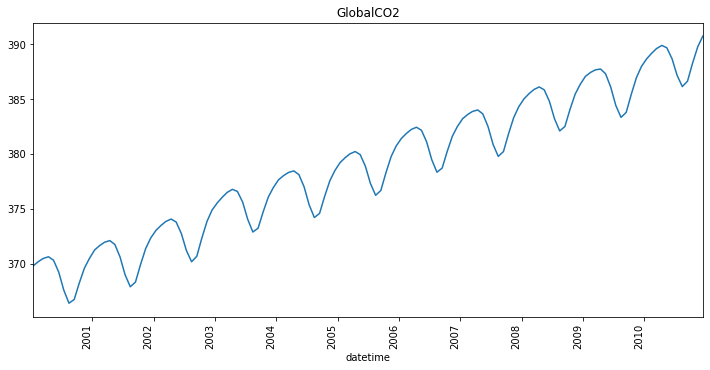

In [43]:
# zooming in
plot_timeseries(co2['2000':'2010'], figsize=(12,6))

The series appears to display an upwards trend.

Apparently, also, there seem to be a seasonality of 12 months. Let's assume this for now, and use it to plot a rolling mean.

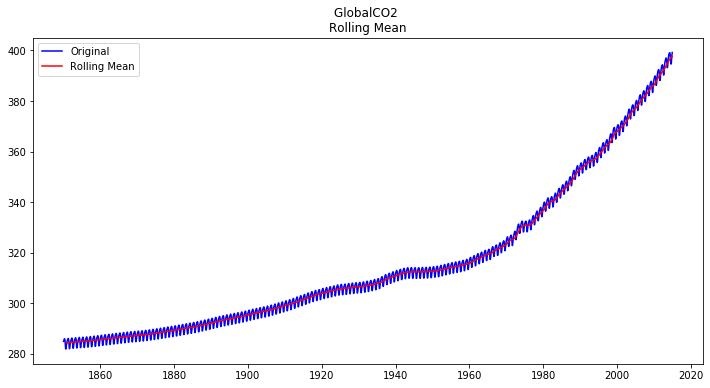

In [44]:
plot_rolling_mean(co2, window=12, figsize=(12,6));

Taking a closer look on a smaller number of "groups" (or bins) and with mean and standard deviation separately.

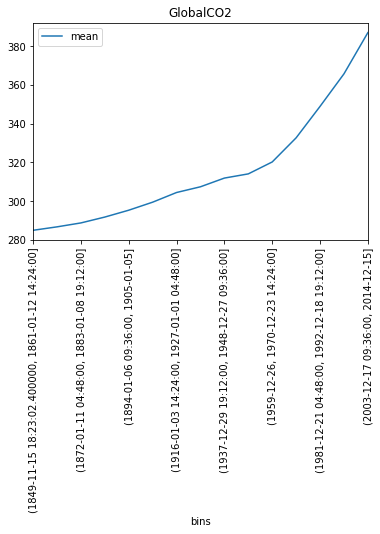

In [45]:
plot_bin_stats(co2, stats_ls=['mean'], figsize=(6,4))

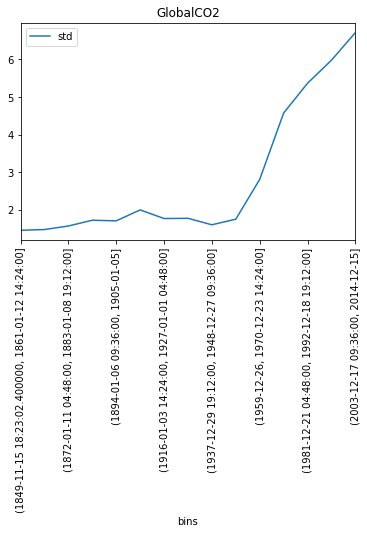

In [46]:
plot_bin_stats(co2, stats_ls=['std'], figsize=(6,4))

After quick inspection, CO2 data violates at least the two characteristics of stationarity:
- it doesn't have constant mean, as there'sa clear upwards trend
- it doesn't have constant variance, as the standard deviation explodes at the end of the time series

In order to model this process, we need to decompose the timeseries and identify its components, and a crucial part of this task is identifying seasonality, both period and type.

In a previous plot we suspected that a seasonal period of 12 months applied (to plot the rolling mean). In order to confirm this hypothesis, we use the ACF plot to identify peak values (high auto-correlation between data points) in lags other than 1.
Also, it's commmon best practice to de-trend the series first, even through a simples rolling mean with a high  number of steps, in order to better visualize the ACF plot.

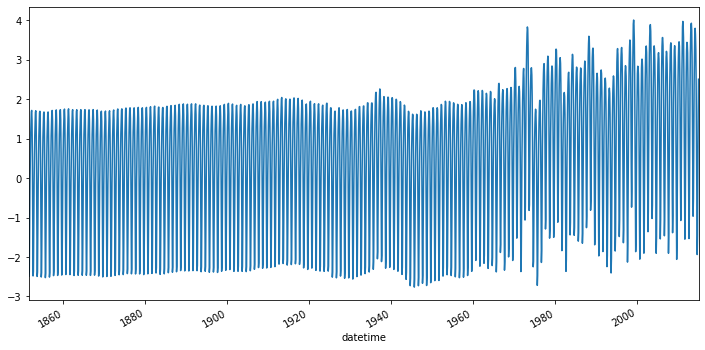

In [47]:
high_n_steps = 20
co2_detrended = (co2 - co2.rolling(high_n_steps).mean()).dropna()
co2_detrended.plot(figsize=(12,6));

Although the trend is not completely gone, now it's much less step. Proceeding:

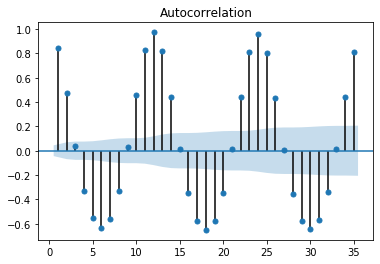

In [48]:
plot_acf(co2_detrended, lags=35, zero=False)
plt.show()

And clear peaks at lags multiples of 12 suggest a seasonal period of 12 applies.

Additionally, the type of seasonality seems to be additive, when the seasonal effect adds up to the trend. It's true the CO2 timeseries, in a grouped (binarized) inspection displayed an increase in standard deviation, which would suggest a multiplicative seasonality. However, the visual inspection seem to suggest the additive seasonality is adequate, and we proceed using this type.

For this reason, it doesn't seem necessary to use a log or square-root transform, which usually help stabilizing variance.

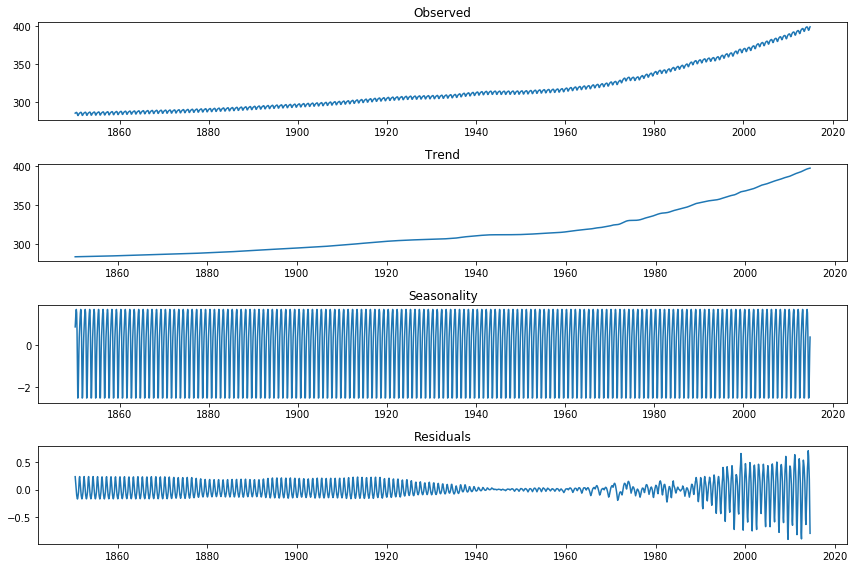

In [49]:
co2_decomp = seasonal_decompose(co2, freq=12, model='aditive')
plot_decomp(co2_decomp, figsize=(12, 8))

It does seem that after 1990 the standard deviation of the series changed its behavior. It may be a good idea to investigate this time frame in particular.

Next, we try to find if differencing may help bring the series to stationarity, in order to later investigate non-seasonal and seasonal auto-regressive and moving average model orders.

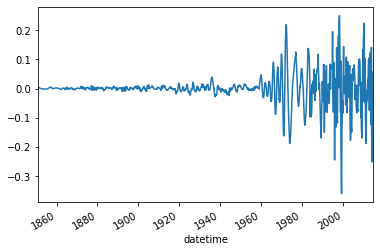

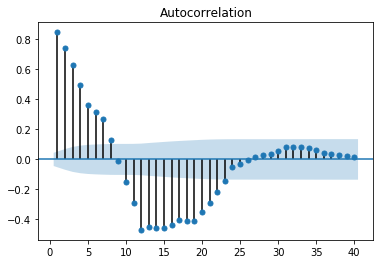

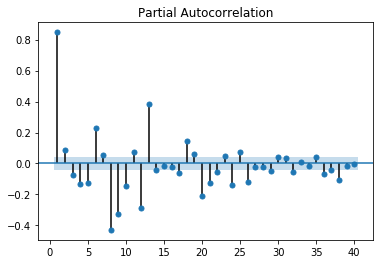

In [50]:
co2_transf = co2.diff().diff(12).dropna()
co2_transf.plot()
plot_acf(co2_transf, lags=40, zero=False)
plot_pacf(co2_transf, lags=40, zero=False)
plt.show()

And investigating a the short period of greater standard deviation after 1990:

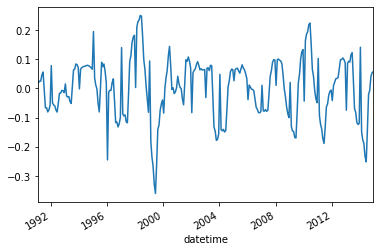

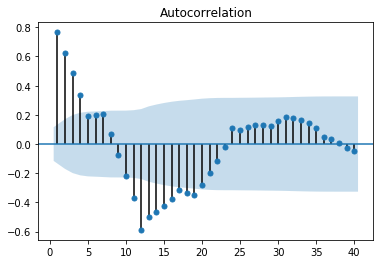

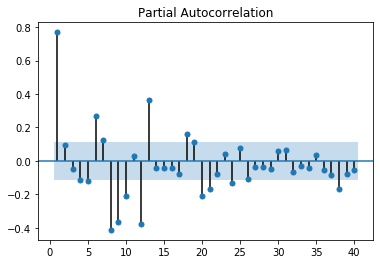

Results of Dickey-Fuller Test:
Test Statistic       -5.669541e+00
p-value               8.988257e-07
# of Lags             1.200000e+01
# of Observations     2.740000e+02
Critical Value 1%    -3.454444e+00
Critical Value 5%    -2.872147e+00
Critical Value 10%   -2.572422e+00
dtype: float64
None


In [51]:
co2_1990 = co2['1990':]
co2_1990_transf = co2_1990.diff().diff(12).dropna()
co2_1990_transf.plot()
plot_acf(co2_1990_transf, lags=40, zero=False)
plot_pacf(co2_1990_transf, lags=40, zero=False)
plt.show()

print(test_adfuller(co2_1990_transf))

As observed above, the CO2 mole concentration is a strongly non-stationary timeseries. In particular:
- There's an upward trend
- There's a strong seasonal component, of period 12
- The variance of the residuals seems to be time dependent

In particular, after first order difference and a seasonal differencing with period 12:
- for the whole dataset, the residuals of the decomposition display a variance highly dependent on time
- for a a time frame after 1990, seems to have achieved a stationary form (ADfuller p-value ~ 0.0000)

Therefore, in terms of prediction accuracy, it's considered best to use only the data after 1990, as it seems to represent a new stage in the process.

## 4.3. Conclusion to Task \#1:

The Land Average Temperature time series
- is non-stationary
- has a upwards trend
- has a high seasonality
- has seemingly normally-distributed residuals after detrending and seasonally differencing
- has no clear order for auto-regressive and moving average models

The CO2 mole concentration:
- is highly non-stationary
- has a very step upwards trend
- has a high seasonality
- has time dependent residuals
- has a very high auto-correlation
- has no clear order for auto-regressive and moving average models

# 5. Task \#2: Correlation vs Causation



Regarding prediction, a variable X may be useful for forecasting a variable Y, but that does not mean X is causing Y$^{[1]}$. In fact it may be that: (1) Y is causing X, or (2) that the relationship between them is more complicated than simple causality.

Good examples are given in [Forecasting: Principles and Practice](https://otexts.com/fpp2/causality.html) online book. In scenario (1), it is possible to model the number of drownings at a beach resort each month with the number of ice-creams sold in the same period. But ice-creams are not causing drownings. People tend to eat more ice-creams on hot days when they are also more likely to go swimming. So the two variables (ice-cream sales and drownings) are correlated, but one is not causing the other. They are both possibly caused by a third variable (temperature). 

In (2), it is possible to forecast if it will rain in the afternoon by observing the number of cyclists on the road in the morning. When there are fewer cyclists than usual, it is more likely to rain later in the day. The model can give reasonable forecasts, not because cyclists prevent rain, but because people are more likely to cycle when the published weather forecast is for a dry day. In this case, there is a causal relationship, but in the opposite direction to our forecasting model. The number of cyclists falls because there is rain forecast. That is, x (rainfall) is affecting y (cyclists).

A common approach in Time Series analysis is to use the Granger causality test. But this approach is not to be used without caution and many argue that Granger causality can't be used as "true" causality.

Hence, especially on a global scale data such as the one in this report, even though it may be that there's a strong correlation between CO2 levels and Average Temperature, and that a Granger causality test yields positive causality, as stated above the problem is probably more complex, and involves many more factors that should be taken into account. Therefore, a more complete causality test would be performed involve a larger number of variables on a global scale, testing for confounding factor etc.

Regarding correlation, in order to compare both time series, we reindex the series to allign datetime indexes.

In [52]:
# aligning both series
co2_reindexed = co2.copy()['1850':].reset_index()
co2_reindexed['datetime'] = co2_reindexed['datetime'].apply(lambda x: x.replace(day=1))
co2_reindexed = co2_reindexed.set_index('datetime').GlobalCO2

landocean_temp_reindexed = landocean_temp['1850':'2014']

From the time series plots displayed in each section, we can already see that both display an increasing trend, but that of the CO2 is much steeper. Exploring the correlation itself.

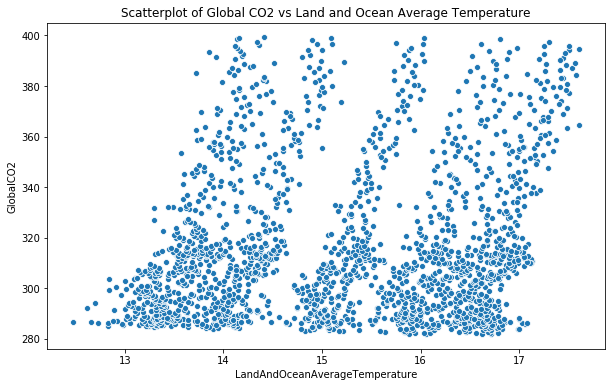

In [53]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=landocean_temp_reindexed, y=co2_reindexed)
plt.title('Scatterplot of Global CO2 vs Land and Ocean Average Temperature')
plt.show()

From the scatterplot, no obvious correlation emerges. It may be that there are "groups" of Temperature and that, within these groups, an increased level of CO2 is associated with a higher Temperature, but this nis not made clear by the plot.

When the Pearson correlation is used to test for linear correlation, results are not particularly high either.

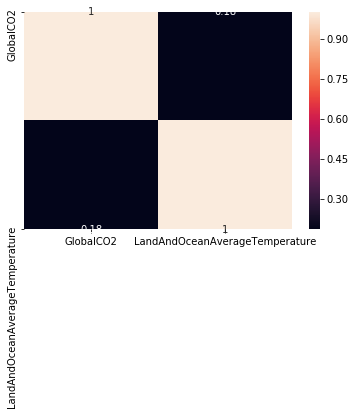

In [54]:
sns.heatmap(pd.concat([co2_reindexed, landocean_temp_reindexed], axis=1).corr(),
            annot=True)
plt.show()

As observed above, the linear correlation between both series is not obvious, although it may be that this correlation follows a non-linear trend.

# 6. Task \#3: Univariate Time Series Prediction

Exponential smoothing and ARIMA models are the two most widely used approaches to time series forecasting, and provide complementary approaches to the problem. While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

To forecast a decomposed time series, we forecast the seasonal component, $S_t$, and the seasonally adjusted component $A_t$, separately. It is usually assumed that the seasonal component is unchanging, or changing extremely slowly, so it is forecast by simply taking the last year of the estimated component. In other words, a seasonal naïve method is used for the seasonal component.


Residuals are useful in checking whether a model has adequately captured the information in the data$^{[1]}$. For a forecasting method to be good, the residuals should have some properties:
1. The residuals should be uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals should have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.
3. The residuals have constant variance.
4. The residuals are normally distributed.

When building models, it's useful to have a baseline, i.e., a starting point in terms of prediction. In time series datathe naive or persistent approach is very common: the nest step in the series is forecast as being equal to the step just before it.

# 6.1. Land and Ocean Temperature

Taking what was learned by seasonal decomposition of the Land and Ocean Average Temperature series, it seems that accounting for trend and seasonality took into consideration all the information needed, as the residuals approximatelly displayed seemingly all of the 4 features for a good model.

Therefore, the [Holt-Winter's model](https://otexts.com/fpp2/holt-winters.html) would be an adequate first approach, as it models both trend and seasonality components, it's fairly easy to implement and could result in very sensible forecasts.

The Mean Squared Error, Mean Absolute Percent Error and Residuals diagnostics will be used to evaluate each model.

**Split into training and test sets**

In [55]:
train_temp, test_temp = landocean_temp_reindexed[:'2010'], landocean_temp_reindexed['2011':]

**The Naive approach**

In [56]:
# predicted_values as array with all values equal to last value in Time Series
predicted_values = np.full(shape=test_temp.shape,
                           fill_value=train_temp[len(train_temp)-1])
naive_predicted_temp = pd.Series(predicted_values, index=test_temp.index)

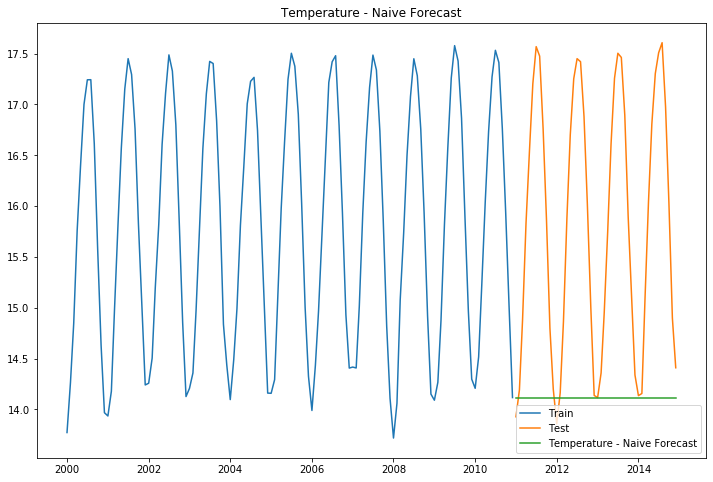

In [57]:
plot_predictions(train_temp['2000':], test_temp, naive_predicted_temp, title="Temperature - Naive Forecast")

Naive Approach
RMSE: 2.1369760810157263
MAPE: 10.398738401046987


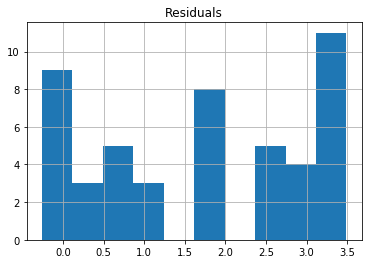

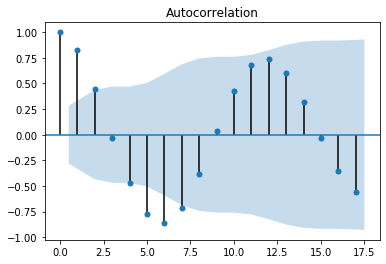

In [58]:
print_diagnostics(test_temp, naive_predicted_temp, 'Naive Approach')

**The Holt-Winter's model**

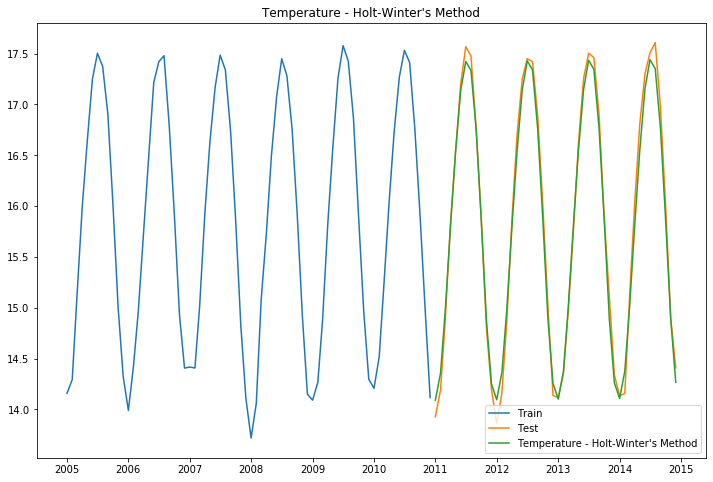

In [59]:
hw = ExponentialSmoothing(np.asarray(train_temp), seasonal_periods=12, trend='add', seasonal='add').fit()
hw_predicted_temp = pd.Series(hw.forecast(len(test_temp)), index=test_temp.index)

plot_predictions(train_temp['2005':], test_temp, hw_predicted_temp, title="Temperature - Holt-Winter's Method")

Holt-Winter's Method
RMSE: 0.12957344584974123
MAPE: 0.6882047181540555


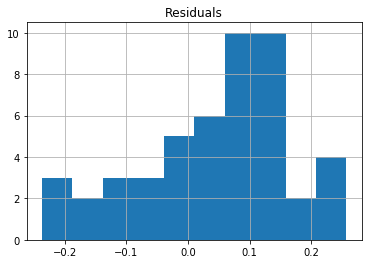

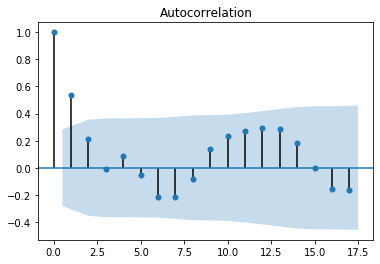

In [60]:
print_diagnostics(test_temp, hw_predicted_temp, 'Holt-Winter\'s Method')

**Comments**

The numeric results for RMSE and MAPE are better than for the Naive approach, which is to be expected. The Residuals, however, display signs of auto-correlation, as the value of ACF function for lag 1 is close to 0.6. As commented previously, the residuals left after seasonal decomposition of the Temperature Series are not completely random. In particular, the Temperature series has a greater variance at the beginning of the, and lower at the end of the series. This behavior should be taken into account as well. One possible approach would be to take a order 1 difference of the series, which could probably transform it into a stationary one. This procedure won't be presented here. 

In conclusion, Holt-Winter's method is a sensible, easy to implement first approach, but further investigation and model development could imporve the performance of the model.

# 6.2. CO2 Time Series

The naive seasonal decomposition of the CO2 series displayed trend and seasonality components, but inspection of the residuals also showed that there's more. Additionally, the ACF plot display a slowly decaying behavior, whereas the PACF plot seem to descrease rapidly after lag 1.

To account for the AutoCorrelation, trend and seasonal components, a Seasonal ARIMA will be used. The seasonal period is 12 months, and the PCAF plot suggest a *p* parameter for the Auto Regressive component of 1. Differencing will be attempted with by trial and error.

The Mean Squared Error, Mean Absolute Percent Error and Residuals diagnostics will be used to compare different classes of models. AIC is used to select between potential models.

**Split into training and test sets**

**The Naive approach**

In [61]:
co2 = co2_reindexed['1990':]
# split into training and test sets
train_co2, test_co2 = co2[:'2010'], co2['2011':]

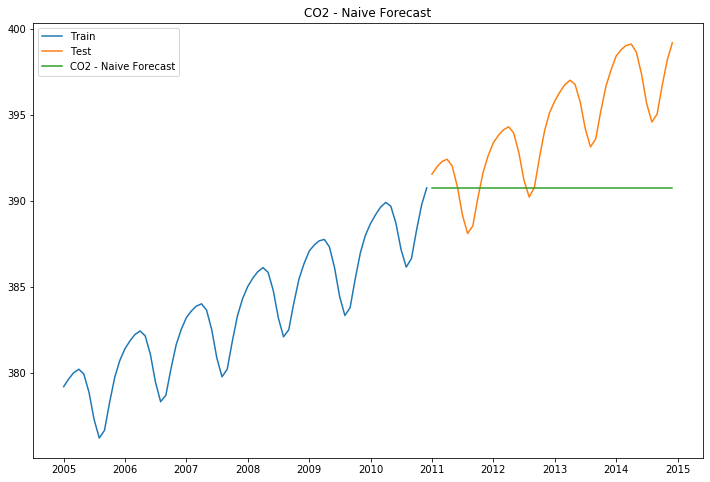

CO2 - Naive Forecast
RMSE: 4.607200989487592
MAPE: 0.976692191688413


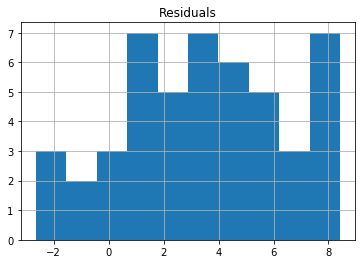

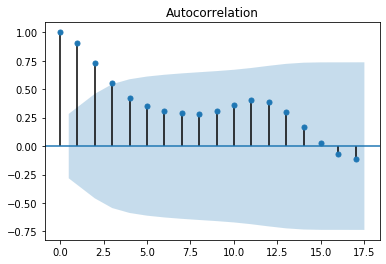

In [62]:
# predicted_values as array with all values equal to last value in Time Series
naive_co2_values = np.full(shape=test_co2.shape,
                           fill_value=train_co2[len(train_co2)-1])
naive_predicted_co2 = pd.Series(naive_co2_values, index=test_co2.index)
# transforming back values with np.exp and plitting them
plot_predictions(train_co2['2005':], test_co2,
                 naive_predicted_co2, 'CO2 - Naive Forecast')
print_diagnostics(test_co2, naive_predicted_co2, 'CO2 - Naive Forecast')

**SARIMA model**

In [63]:
co2_sarima= pm.auto_arima(
    train_co2,
    d=1,
    start_p=1, start_q=1,
    max_p=2, max_q=2,
    seasonal=True,
    m=12, D=1,
    start_P=1, start_Q=1,
    max_P=2, max_Q=2,
    information_criterion='aic',
    trace=True, # print results whilst training
    error_action='ignore', # ignore orders that don't work
    stepwise=True, # apply intelligent order search
)

Performing stepwise search to minimize aic
Fit ARIMA: (1, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-800.385, BIC=-779.526, Time=4.622 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-413.874, BIC=-406.921, Time=0.142 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 0, 12) (constant=True); AIC=-792.263, BIC=-778.357, Time=1.366 seconds
Fit ARIMA: (0, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-674.443, BIC=-660.537, Time=1.690 seconds
Fit ARIMA: (0, 1, 0)x(0, 1, 0, 12) (constant=False); AIC=-414.937, BIC=-411.460, Time=0.104 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 1, 12) (constant=True); AIC=-768.045, BIC=-750.663, Time=1.176 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 0, 12) (constant=True); AIC=-792.316, BIC=-774.933, Time=2.982 seconds


/home/alvaroac/miniconda3/envs/ts_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 1)x(2, 1, 1, 12) (constant=True); AIC=-795.601, BIC=-771.265, Time=6.122 seconds
Fit ARIMA: (1, 1, 1)x(1, 1, 2, 12) (constant=True); AIC=-799.133, BIC=-774.798, Time=5.006 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 0, 12) (constant=True); AIC=-634.650, BIC=-620.744, Time=0.383 seconds
Fit ARIMA: (1, 1, 1)x(0, 1, 2, 12) (constant=True); AIC=-789.142, BIC=-768.283, Time=3.382 seconds


/home/alvaroac/miniconda3/envs/ts_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 1)x(2, 1, 0, 12) (constant=True); AIC=-797.317, BIC=-776.458, Time=5.345 seconds


/home/alvaroac/miniconda3/envs/ts_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 1)x(2, 1, 2, 12) (constant=True); AIC=-796.563, BIC=-768.751, Time=9.384 seconds
Fit ARIMA: (0, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-690.169, BIC=-672.786, Time=1.375 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=-801.276, BIC=-783.894, Time=2.015 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 1, 12) (constant=True); AIC=-770.001, BIC=-756.095, Time=0.864 seconds


/home/alvaroac/miniconda3/envs/ts_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 0)x(2, 1, 1, 12) (constant=True); AIC=-796.121, BIC=-775.262, Time=4.817 seconds
Fit ARIMA: (1, 1, 0)x(1, 1, 2, 12) (constant=True); AIC=-801.047, BIC=-780.188, Time=6.514 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 0, 12) (constant=True); AIC=-635.108, BIC=-624.678, Time=0.274 seconds
Fit ARIMA: (1, 1, 0)x(0, 1, 2, 12) (constant=True); AIC=-790.473, BIC=-773.090, Time=4.184 seconds
Fit ARIMA: (1, 1, 0)x(2, 1, 0, 12) (constant=True); AIC=-797.359, BIC=-779.977, Time=3.559 seconds


/home/alvaroac/miniconda3/envs/ts_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (1, 1, 0)x(2, 1, 2, 12) (constant=True); AIC=-797.651, BIC=-773.315, Time=7.446 seconds
Fit ARIMA: (0, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=-552.527, BIC=-538.622, Time=0.911 seconds


/home/alvaroac/miniconda3/envs/ts_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: (2, 1, 0)x(1, 1, 1, 12) (constant=True); AIC=-800.499, BIC=-779.640, Time=2.318 seconds
Fit ARIMA: (2, 1, 1)x(1, 1, 1, 12) (constant=True); AIC=-798.345, BIC=-774.010, Time=2.480 seconds
Total fit time: 78.481 seconds


/home/alvaroac/miniconda3/envs/ts_env/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


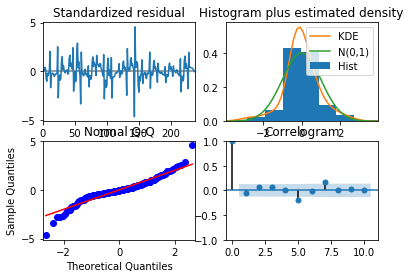

In [64]:
co2_sarima.plot_diagnostics();

In [65]:
co2_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  252
Model:             SARIMAX(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                 405.638
Date:                              Wed, 04 Mar 2020   AIC                           -801.276
Time:                                      21:34:03   BIC                           -783.894
Sample:                                           0   HQIC                          -794.271
                                              - 252                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0013      0.002      0.739      0.460      -0.002       0.005
ar.L1          0.8159      0.044     18.439      0.000       0.729       0.903
ar.S.L12      -0.5359      0.048    -11.140      0.000      -0.630      -0.442
ma.S.L12      -0.3847      0.065     -5.922      0.000      -0.512      -0.257
sigma2         0.0019      0.000     13.890      0.000       0.002       0.002
===================================================================================
Ljung-Box (Q):                       58.88   Jarque-Bera (JB):               171.72
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
sarima_predictions, sarima_conf_int = \
    co2_sarima.predict(n_periods=len(test_co2),
                       return_conf_int=True)
co2_sarima_predictions = pd.Series(sarima_predictions, index=test_co2.index)

In [67]:
conf_intervs = sarima_conf_int.T
upper_bound = conf_intervs[1]
lower_bound = conf_intervs[0]

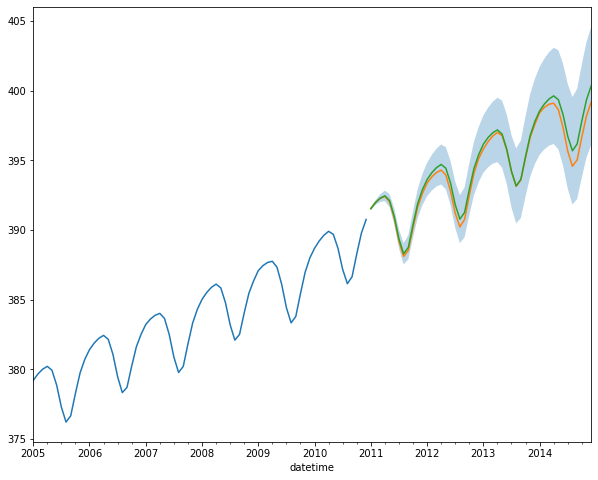

In [68]:
train_co2['2005':].plot()
test_co2.plot()
co2_sarima_predictions.plot(figsize=(10,8))
plt.fill_between(test_co2.index, lower_bound, upper_bound, alpha=0.3)
plt.show()

As a first approach, the SARIMA model seemed to predict test data fairly. Evaluation metrics such as RMSE and MAPE were reduced  when compared to the Naive approach. However, it's true that visually the predictions seem to systematically miss. Also, the residuals' ACF plot is still displaying autocorrelation between values. As observed earlier, there's a variance explosion after 1960. In future models, this process should be investigated deeper and modelled, in order to take this variation into account and possibly improve results.

# 7. Task \#4: Multivariate Prediction 

# 8. References

\[1\] Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 2019-01-12.

\[2\] Brownlee, J. (2017) Seasonal Persistence Forecasting With Python, https://machinelearningmastery.com/seasonal-persistence-forecasting-python/. Acsessed on 2019-01-12.

\[3\] Jain, A. (2016) A comprehensive beginner’s guide to create a Time Series Forecast (with Codes in Python and R), https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/. Acsessed on 2019-01-12.
